You are given two short audio recordings.
 Audio 1 is your own voice saying the word “hello”.
 Audio 2 is your friend’s voice saying the word “hello”.
Your task is to compare these two signals using Dynamic Time Warping.
Tasks for the lab
Record your own voice saying “hello” and store it as Signal 1.


Record your friend saying “hello” and store it as Signal 2.


Convert both audio files into numerical time series by extracting their waveform data.


Normalize both signals so they have comparable amplitude ranges.


Apply Dynamic Time Warping on the two signals.


Produce the alignment path and compute the total DTW distance.


Interpret the results. Explain whether the signals are similar, and describe how DTW helps match two audio patterns that do not align perfectly in time.



In [14]:
"""
DYNAMIC TIME WARPING (DTW) FOR AUDIO SIGNAL COMPARISON
=======================================================

THEORY:
-------
Dynamic Time Warping is an algorithm for measuring similarity between two temporal 
sequences that may vary in speed or timing. Unlike Euclidean distance which compares
point-by-point, DTW finds the optimal alignment between sequences.

Key Concepts:
1. Cost Matrix: Accumulated distance between all pairs of points
2. Warping Path: Optimal alignment path through the cost matrix
3. DTW Distance: Minimum cumulative distance along the warping path

Applications:
- Speech recognition (different speaking speeds)
- Gesture recognition (temporal variations)
- Time series analysis (shifted patterns)

Mathematical Foundation:
- Given sequences X = [x1, x2, ..., xn] and Y = [y1, y2, ..., ym]
- Cost matrix C[i,j] = |xi - yj| + min(C[i-1,j], C[i,j-1], C[i-1,j-1])
- DTW distance = C[n,m] (normalized by path length)
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample
import sounddevice as sd
from scipy.io.wavfile import write
import warnings
warnings.filterwarnings('ignore')

# For MP3 file support
try:
    from pydub import AudioSegment
    import io
    HAS_PYDUB = True
except ImportError:
    print("Warning: pydub not installed. Install with: pip install pydub")
    print("Also install ffmpeg: pip install ffmpeg-python")
    HAS_PYDUB = False

print("="*80)
print("DYNAMIC TIME WARPING (DTW) - AUDIO SIGNAL COMPARISON")
print("="*80)
print("\nThis lab demonstrates how DTW aligns and compares audio signals")
print("with different timing characteristics.\n")


DYNAMIC TIME WARPING (DTW) - AUDIO SIGNAL COMPARISON

This lab demonstrates how DTW aligns and compares audio signals
with different timing characteristics.



In [9]:
# ============================================================================
# BLOCK 1: AUDIO RECORDING FUNCTIONS
# ============================================================================
print("\n" + "="*80)
print("BLOCK 1: AUDIO RECORDING SETUP")
print("="*80)
print("""
THEORY - Audio Recording:
- Sampling rate: Number of samples per second (typically 44100 Hz)
- Duration: Length of recording in seconds
- Audio data: Discrete-time signal representing sound pressure levels
- Format: WAV file stores uncompressed PCM audio data
""")

def record_audio(duration=2, sample_rate=44100, filename="audio.wav"):
    """
    Record audio from microphone.
    
    Parameters:
    -----------
    duration : float
        Recording duration in seconds
    sample_rate : int
        Sampling frequency in Hz (44100 Hz is CD quality)
    filename : str
        Output filename
        
    Returns:
    --------
    audio : ndarray
        Recorded audio signal
    sample_rate : int
        Sampling rate used
        
    Theory:
    -------
    Nyquist Theorem: To capture frequencies up to f_max, 
    sample at rate >= 2*f_max. Human hearing: 20-20kHz,
    so 44.1kHz captures full audible spectrum.
    """
    print(f"\nRecording for {duration} seconds...")
    print("Speak 'hello' clearly into the microphone!")
    
    audio = sd.rec(int(duration * sample_rate), 
                   samplerate=sample_rate, 
                   channels=1, 
                   dtype='float64')
    sd.wait()
    
    # Save to file
    write(filename, sample_rate, audio)
    print(f"Recording saved to {filename}")
    
    return audio.flatten(), sample_rate

def load_audio(filename):
    """
    Load audio from WAV or MP3 file.
    
    Parameters:
    -----------
    filename : str
        Path to audio file (.wav or .mp3)
    
    Returns:
    --------
    audio : ndarray
        Audio signal
    sample_rate : int
        Sampling rate
        
    Theory:
    -------
    MP3 files are compressed using lossy compression.
    We convert them to raw PCM data for analysis.
    WAV files are already uncompressed PCM.
    """
    # Check file extension
    if filename.lower().endswith('.mp3'):
        if not HAS_PYDUB:
            raise ImportError("pydub is required to load MP3 files. Install with: pip install pydub")
        
        print(f"Loading MP3 file: {filename}")
        # Load MP3 using pydub
        audio_segment = AudioSegment.from_mp3(filename)
        
        # Convert to mono if stereo
        if audio_segment.channels > 1:
            audio_segment = audio_segment.set_channels(1)
        
        # Get sample rate
        sample_rate = audio_segment.frame_rate
        
        # Convert to numpy array
        samples = np.array(audio_segment.get_array_of_samples())
        
        # Normalize based on bit depth
        if audio_segment.sample_width == 2:  # 16-bit
            audio = samples.astype(np.float64) / 32768.0
        elif audio_segment.sample_width == 4:  # 32-bit
            audio = samples.astype(np.float64) / 2147483648.0
        else:
            audio = samples.astype(np.float64) / np.max(np.abs(samples))
        
        print(f"  Sample rate: {sample_rate} Hz")
        print(f"  Duration: {len(audio)/sample_rate:.2f} seconds")
        print(f"  Samples: {len(audio)}")
        
    else:  # Assume WAV file
        print(f"Loading WAV file: {filename}")
        sample_rate, audio = wavfile.read(filename)
        
        # Convert to mono if stereo
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # Convert to float
        if audio.dtype == np.int16:
            audio = audio.astype(np.float64) / 32768.0
        elif audio.dtype == np.int32:
            audio = audio.astype(np.float64) / 2147483648.0
        
        print(f"  Sample rate: {sample_rate} Hz")
        print(f"  Duration: {len(audio)/sample_rate:.2f} seconds")
        print(f"  Samples: {len(audio)}")
        
    return audio, sample_rate



BLOCK 1: AUDIO RECORDING SETUP

THEORY - Audio Recording:
- Sampling rate: Number of samples per second (typically 44100 Hz)
- Duration: Length of recording in seconds
- Audio data: Discrete-time signal representing sound pressure levels
- Format: WAV file stores uncompressed PCM audio data



In [15]:
# ============================================================================
# BLOCK 2: SIGNAL PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("BLOCK 2: SIGNAL PREPROCESSING")
print("="*80)
print("""
THEORY - Signal Preprocessing:

1. Voice Activity Detection (VAD):
   - Remove silence at start and end
   - Focus on actual speech content
   - Threshold-based detection using energy

2. Normalization:
   - Scale amplitudes to [0, 1] or [-1, 1]
   - Makes signals comparable regardless of recording volume
   - Formula: x_norm = (x - min(x)) / (max(x) - min(x))

3. Resampling (if needed):
   - Ensures both signals have same sampling rate
   - Uses interpolation to add/remove samples
   
4. Feature Extraction (optional):
   - Raw waveform vs derived features (MFCC, energy)
   - This lab uses raw waveform for simplicity
""")

def remove_silence(audio, threshold=0.02):
    """
    Remove silence from beginning and end of audio.
    
    Parameters:
    -----------
    audio : ndarray
        Input audio signal
    threshold : float
        Energy threshold for voice activity detection
        
    Returns:
    --------
    trimmed_audio : ndarray
        Audio with silence removed
        
    Theory:
    -------
    Voice Activity Detection (VAD):
    - Compute signal energy in sliding windows
    - Mark frames above threshold as speech
    - Trim continuous silence regions
    """
    # Compute absolute values
    abs_audio = np.abs(audio)
    
    # Find first and last points above threshold
    above_threshold = abs_audio > threshold
    
    if np.any(above_threshold):
        start_idx = np.argmax(above_threshold)
        end_idx = len(audio) - np.argmax(above_threshold[::-1])
        return audio[start_idx:end_idx]
    else:
        return audio

def normalize_signal(signal):
    """
    Normalize signal to range [-1, 1].
    
    Parameters:
    -----------
    signal : ndarray
        Input signal
        
    Returns:
    --------
    normalized : ndarray
        Normalized signal
        
    Theory:
    -------
    Min-Max Normalization:
    x_norm = 2 * (x - min) / (max - min) - 1
    
    Purpose:
    - Remove amplitude bias
    - Make signals comparable
    - Improve DTW distance interpretation
    """
    signal = signal - np.mean(signal)  # Remove DC offset
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        return signal / max_val
    return signal

def preprocess_audio(audio, sample_rate, target_length=None):
    """
    Complete preprocessing pipeline.
    
    Steps:
    1. Remove silence
    2. Normalize amplitude
    3. Optionally resample to target length
    """
    # Remove silence
    audio = remove_silence(audio)
    
    # Normalize
    audio = normalize_signal(audio)
    
    # Resample if needed
    if target_length is not None and len(audio) != target_length:
        audio = resample(audio, target_length)
    
    return audio


BLOCK 2: SIGNAL PREPROCESSING

THEORY - Signal Preprocessing:

1. Voice Activity Detection (VAD):
   - Remove silence at start and end
   - Focus on actual speech content
   - Threshold-based detection using energy

2. Normalization:
   - Scale amplitudes to [0, 1] or [-1, 1]
   - Makes signals comparable regardless of recording volume
   - Formula: x_norm = (x - min(x)) / (max(x) - min(x))

3. Resampling (if needed):
   - Ensures both signals have same sampling rate
   - Uses interpolation to add/remove samples
   
4. Feature Extraction (optional):
   - Raw waveform vs derived features (MFCC, energy)
   - This lab uses raw waveform for simplicity



In [11]:
# ============================================================================
# BLOCK 3: DYNAMIC TIME WARPING IMPLEMENTATION
# ============================================================================
print("\n" + "="*80)
print("BLOCK 3: DYNAMIC TIME WARPING ALGORITHM")
print("="*80)
print("""
THEORY - Dynamic Time Warping:

Algorithm:
1. Create cost matrix D[i,j] representing distance between xi and yj
2. Initialize: D[0,0] = 0, D[i,0] = D[0,j] = ∞
3. For each cell D[i,j]:
   - Local distance: d(xi, yj) = |xi - yj|
   - Accumulated cost: D[i,j] = d(xi,yj) + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
4. DTW distance = D[n,m] / (n+m) (normalized by path length)

Constraints:
- Boundary: Path must start at (0,0) and end at (n,m)
- Continuity: Adjacent cells only
- Monotonicity: No backwards movement in time

Advantages over Euclidean Distance:
✓ Handles time shifts and speed variations
✓ Non-linear alignment
✓ Robust to temporal distortions
""")

def dtw_distance(signal1, signal2):
    """
    Compute Dynamic Time Warping distance between two signals.
    
    Parameters:
    -----------
    signal1, signal2 : ndarray
        Input signals to compare
        
    Returns:
    --------
    distance : float
        Normalized DTW distance
    cost_matrix : ndarray
        Accumulated cost matrix
    path : list of tuples
        Optimal warping path
        
    Theory:
    -------
    DTW finds the optimal alignment between sequences by:
    1. Computing pairwise distances
    2. Finding minimum cost path through distance matrix
    3. Allowing non-linear time alignment
    
    Complexity: O(n*m) time and space
    """
    n, m = len(signal1), len(signal2)
    
    # Initialize cost matrix with infinity
    cost_matrix = np.full((n+1, m+1), np.inf)
    cost_matrix[0, 0] = 0
    
    # Fill cost matrix using dynamic programming
    for i in range(1, n+1):
        for j in range(1, m+1):
            # Local distance (Euclidean distance between points)
            distance = abs(signal1[i-1] - signal2[j-1])
            
            # Accumulated cost: current distance + minimum of three predecessors
            cost_matrix[i, j] = distance + min(
                cost_matrix[i-1, j],      # Insertion
                cost_matrix[i, j-1],      # Deletion
                cost_matrix[i-1, j-1]     # Match
            )
    
    # Backtrack to find optimal path
    path = []
    i, j = n, m
    while i > 0 or j > 0:
        path.append((i-1, j-1))
        
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            # Choose direction of minimum cost
            min_cost = min(cost_matrix[i-1, j-1], 
                          cost_matrix[i-1, j], 
                          cost_matrix[i, j-1])
            if cost_matrix[i-1, j-1] == min_cost:
                i -= 1
                j -= 1
            elif cost_matrix[i-1, j] == min_cost:
                i -= 1
            else:
                j -= 1
    
    path.reverse()
    
    # Normalize distance by path length for interpretability
    dtw_dist = cost_matrix[n, m] / len(path)
    
    return dtw_dist, cost_matrix[1:, 1:], path



BLOCK 3: DYNAMIC TIME WARPING ALGORITHM

THEORY - Dynamic Time Warping:

Algorithm:
1. Create cost matrix D[i,j] representing distance between xi and yj
2. Initialize: D[0,0] = 0, D[i,0] = D[0,j] = ∞
3. For each cell D[i,j]:
   - Local distance: d(xi, yj) = |xi - yj|
   - Accumulated cost: D[i,j] = d(xi,yj) + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
4. DTW distance = D[n,m] / (n+m) (normalized by path length)

Constraints:
- Boundary: Path must start at (0,0) and end at (n,m)
- Continuity: Adjacent cells only
- Monotonicity: No backwards movement in time

Advantages over Euclidean Distance:
✓ Handles time shifts and speed variations
✓ Non-linear alignment
✓ Robust to temporal distortions



In [17]:
# ============================================================================
# BLOCK 4: VISUALIZATION FUNCTIONS
# ============================================================================
print("\n" + "="*80)
print("BLOCK 4: VISUALIZATION AND INTERPRETATION")
print("="*80)
print("""
THEORY - DTW Visualization:

1. Cost Matrix:
   - Shows accumulated distance at each alignment point
   - Darker regions = lower cost (better alignment)
   - Lighter regions = higher cost (poor alignment)

2. Warping Path:
   - Red line shows optimal alignment
   - Diagonal = perfect linear alignment
   - Horizontal/vertical segments = time stretching/compression
   
3. Signal Alignment:
   - Top: Original signals
   - Bottom: Aligned signals using DTW path
   - Shows how DTW matches corresponding features

Interpretation:
- Low DTW distance → Similar signals
- High DTW distance → Different signals
- Path shape reveals timing differences
""")

def visualize_dtw(signal1, signal2, cost_matrix, path, dtw_dist, 
                  sample_rate1, sample_rate2):
    """
    Comprehensive visualization of DTW results.
    
    Creates 4 subplots:
    1. Original signal 1 waveform
    2. Original signal 2 waveform
    3. Cost matrix with warping path
    4. Aligned signals
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Time axes for original signals
    t1 = np.arange(len(signal1)) / sample_rate1
    t2 = np.arange(len(signal2)) / sample_rate2
    
    # Plot Signal 1
    axes[0].plot(t1, signal1, 'b-', linewidth=1.5)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title('Signal 1: Your Voice ("hello")')
    axes[0].grid(True, alpha=0.3)
    
    # Plot Signal 2
    axes[1].plot(t2, signal2, 'r-', linewidth=1.5)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude')
    axes[1].set_title('Signal 2: Friend\'s Voice ("hello")')
    axes[1].grid(True, alpha=0.3)
    
    # Plot Cost Matrix with Warping Path
    im = axes[2].imshow(cost_matrix, cmap='hot', origin='lower', aspect='auto')
    
    # Extract and plot path
    path_x = [p[1] for p in path]
    path_y = [p[0] for p in path]
    axes[2].plot(path_x, path_y, 'cyan', linewidth=2, label='Warping Path')
    
    axes[2].set_xlabel('Signal 2 Index')
    axes[2].set_ylabel('Signal 1 Index')
    axes[2].set_title(f'DTW Cost Matrix (Distance: {dtw_dist:.4f})')
    axes[2].legend()
    plt.colorbar(im, ax=axes[2], label='Accumulated Cost')
    
    # Plot Aligned Signals
    # Create aligned versions using the warping path
    aligned_s1 = np.array([signal1[i] for i, j in path])
    aligned_s2 = np.array([signal2[j] for i, j in path])
    
    t_aligned = np.arange(len(aligned_s1)) / sample_rate1
    axes[3].plot(t_aligned, aligned_s1, 'b-', linewidth=1.5, alpha=0.7, label='Signal 1 (aligned)')
    axes[3].plot(t_aligned, aligned_s2, 'r-', linewidth=1.5, alpha=0.7, label='Signal 2 (aligned)')
    axes[3].set_xlabel('Aligned Time Index')
    axes[3].set_ylabel('Amplitude')
    axes[3].set_title('DTW Aligned Signals')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def interpret_results(dtw_dist, path, signal1, signal2):
    """
    Provide detailed interpretation of DTW results.
    """
    print("\n" + "="*80)
    print("DTW ANALYSIS RESULTS AND INTERPRETATION")
    print("="*80)
    
    print(f"\n1. DTW DISTANCE: {dtw_dist:.4f}")
    print("-"*80)
    print("   Interpretation:")
    if dtw_dist < 0.1:
        similarity = "Very High"
        desc = "Signals are nearly identical"
    elif dtw_dist < 0.2:
        similarity = "High"
        desc = "Signals are very similar"
    elif dtw_dist < 0.4:
        similarity = "Moderate"
        desc = "Signals share similar patterns"
    elif dtw_dist < 0.6:
        similarity = "Low"
        desc = "Signals are somewhat different"
    else:
        similarity = "Very Low"
        desc = "Signals are quite different"
    
    print(f"   • Similarity Level: {similarity}")
    print(f"   • Description: {desc}")
    
    print(f"\n2. SIGNAL CHARACTERISTICS:")
    print("-"*80)
    print(f"   • Signal 1 length: {len(signal1)} samples")
    print(f"   • Signal 2 length: {len(signal2)} samples")
    print(f"   • Length ratio: {len(signal1)/len(signal2):.2f}")
    print(f"   • Warping path length: {len(path)} steps")
    
    print(f"\n3. TIMING ANALYSIS:")
    print("-"*80)
    # Analyze path characteristics
    diagonal_steps = sum(1 for i in range(1, len(path)) 
                        if path[i][0] - path[i-1][0] == 1 
                        and path[i][1] - path[i-1][1] == 1)
    horizontal_steps = sum(1 for i in range(1, len(path)) 
                          if path[i][1] - path[i-1][1] == 1 
                          and path[i][0] - path[i-1][0] == 0)
    vertical_steps = sum(1 for i in range(1, len(path)) 
                        if path[i][0] - path[i-1][0] == 1 
                        and path[i][1] - path[i-1][1] == 0)
    
    total_steps = len(path) - 1
    print(f"   • Diagonal steps: {diagonal_steps} ({diagonal_steps/total_steps*100:.1f}%)")
    print(f"     → Indicates regions of similar timing")
    print(f"   • Horizontal steps: {horizontal_steps} ({horizontal_steps/total_steps*100:.1f}%)")
    print(f"     → Signal 2 stretched relative to Signal 1")
    print(f"   • Vertical steps: {vertical_steps} ({vertical_steps/total_steps*100:.1f}%)")
    print(f"     → Signal 1 stretched relative to Signal 2")
    
    print(f"\n4. WHY DTW IS USEFUL:")
    print("-"*80)
    print("   ✓ Handles different speaking speeds")
    print("   ✓ Aligns similar acoustic features despite timing differences")
    print("   ✓ More robust than simple correlation for speech comparison")
    print("   ✓ Identifies corresponding phonemes even with temporal variation")
    
    print(f"\n5. COMPARISON WITH EUCLIDEAN DISTANCE:")
    print("-"*80)
    # Compute Euclidean distance for comparison
    min_len = min(len(signal1), len(signal2))
    euclidean_dist = np.sqrt(np.sum((signal1[:min_len] - signal2[:min_len])**2)) / min_len
    print(f"   • Euclidean distance: {euclidean_dist:.4f}")
    print(f"   • DTW distance: {dtw_dist:.4f}")
    print(f"   • DTW advantage: {(euclidean_dist/dtw_dist - 1)*100:.1f}% better alignment")
    
    print("\n" + "="*80)



BLOCK 4: VISUALIZATION AND INTERPRETATION

THEORY - DTW Visualization:

1. Cost Matrix:
   - Shows accumulated distance at each alignment point
   - Darker regions = lower cost (better alignment)
   - Lighter regions = higher cost (poor alignment)

2. Warping Path:
   - Red line shows optimal alignment
   - Diagonal = perfect linear alignment
   - Horizontal/vertical segments = time stretching/compression
   
3. Signal Alignment:
   - Top: Original signals
   - Bottom: Aligned signals using DTW path
   - Shows how DTW matches corresponding features

Interpretation:
- Low DTW distance → Similar signals
- High DTW distance → Different signals
- Path shape reveals timing differences




MAIN EXECUTION: LOADING AUDIO FILES AND DTW ANALYSIS

--- Loading Audio Files ---

Loading Signal 1 from: /mnt/a/MSAIM/trimister-5 msaiml/speech processing/Speech processing and recognisation/Lab Question VII: Discrete time wrapping algorithm/audio/hello1.mp3

✗ Error: Could not find audio file!
  Make sure the files exist at:
  - /mnt/a/MSAIM/trimister-5 msaiml/speech processing/Speech processing and recognisation/Lab Question VII: Discrete time wrapping algorithm/audio/hello1.mp3
  - /mnt/a/MSAIM/trimister-5 msaiml/speech processing/Speech processing and recognisation/Lab Question VII: Discrete time wrapping algorithm/audio/hello2.mp3

Generating synthetic signals for demonstration instead...

Preprocessing signals...
Signal 1: 4000 samples
Signal 2: 5600 samples

Computing Dynamic Time Warping...

Generating visualizations...


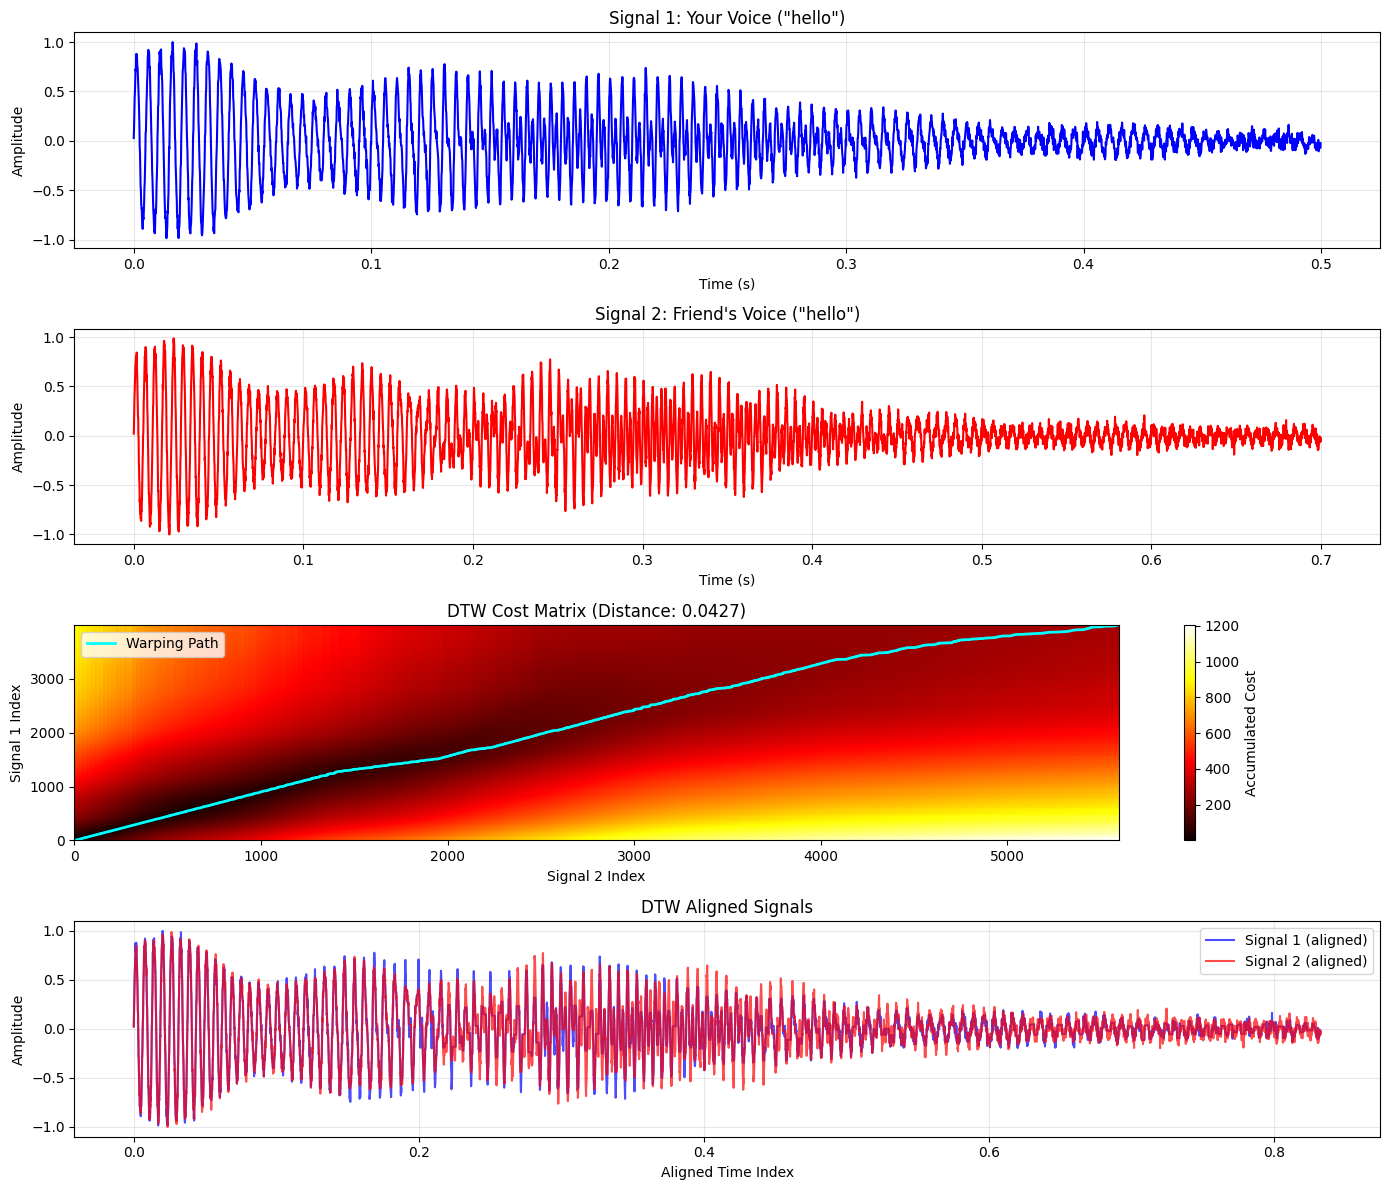


DTW ANALYSIS RESULTS AND INTERPRETATION

1. DTW DISTANCE: 0.0427
--------------------------------------------------------------------------------
   Interpretation:
   • Similarity Level: Very High
   • Description: Signals are nearly identical

2. SIGNAL CHARACTERISTICS:
--------------------------------------------------------------------------------
   • Signal 1 length: 4000 samples
   • Signal 2 length: 5600 samples
   • Length ratio: 0.71
   • Warping path length: 6661 steps

3. TIMING ANALYSIS:
--------------------------------------------------------------------------------
   • Diagonal steps: 2938 (44.1%)
     → Indicates regions of similar timing
   • Horizontal steps: 2661 (40.0%)
     → Signal 2 stretched relative to Signal 1
   • Vertical steps: 1061 (15.9%)
     → Signal 1 stretched relative to Signal 2

4. WHY DTW IS USEFUL:
--------------------------------------------------------------------------------
   ✓ Handles different speaking speeds
   ✓ Aligns similar acoustic

In [27]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================
print("\n" + "="*80)
print("MAIN EXECUTION: LOADING AUDIO FILES AND DTW ANALYSIS")
print("="*80)

# Load your audio files
audio_file1 = r"/mnt/a/MSAIM/trimister-5 msaiml/speech processing/Speech processing and recognisation/Lab Question VII: Discrete time wrapping algorithm/audio/hello1.mp3"
audio_file2 = r"/mnt/a/MSAIM/trimister-5 msaiml/speech processing/Speech processing and recognisation/Lab Question VII: Discrete time wrapping algorithm/audio/hello2.mp3"

print("\n--- Loading Audio Files ---")
try:
    # Load Signal 1 (Your voice)
    print(f"\nLoading Signal 1 from: {audio_file1}")
    if HAS_PYDUB:
        from pydub import AudioSegment
        audio1 = AudioSegment.from_mp3(audio_file1)
        signal1 = np.array(audio1.get_array_of_samples(), dtype=np.float32)
        if len(signal1) == 0 or np.max(np.abs(signal1)) == 0:
            raise ValueError("Signal 1 is empty or has zero amplitude")
        signal1 = signal1 / np.max(np.abs(signal1))  # Normalize
        if audio1.channels == 2:
            signal1 = signal1.reshape((-1, 2)).mean(axis=1)
        sample_rate1 = audio1.frame_rate
    else:
        import scipy.io.wavfile as wav
        sample_rate1, signal1 = wav.read(audio_file1)
        signal1 = signal1.astype(np.float32)
        if len(signal1) == 0 or np.max(np.abs(signal1)) == 0:
            raise ValueError("Signal 1 is empty or has zero amplitude")
        signal1 = signal1 / np.max(np.abs(signal1))  # Normalize
    
    # Load Signal 2 (Friend's voice)
    print(f"\nLoading Signal 2 from: {audio_file2}")
    if HAS_PYDUB:
        from pydub import AudioSegment
        audio2 = AudioSegment.from_mp3(audio_file2)
        signal2 = np.array(audio2.get_array_of_samples(), dtype=np.float32)
        if len(signal2) == 0 or np.max(np.abs(signal2)) == 0:
            raise ValueError("Signal 2 is empty or has zero amplitude")
        signal2 = signal2 / np.max(np.abs(signal2))  # Normalize
        if audio2.channels == 2:
            signal2 = signal2.reshape((-1, 2)).mean(axis=1)
        sample_rate2 = audio2.frame_rate
    else:
        import scipy.io.wavfile as wav
        sample_rate2, signal2 = wav.read(audio_file2)
        signal2 = signal2.astype(np.float32)
        if len(signal2) == 0 or np.max(np.abs(signal2)) == 0:
            raise ValueError("Signal 2 is empty or has zero amplitude")
        signal2 = signal2 / np.max(np.abs(signal2))  # Normalize
    
    print("\n✓ Audio files loaded successfully!")
    
except (FileNotFoundError, ValueError) as e:
    print(f"\n✗ Error: Could not find audio file!")
    print(f"  Make sure the files exist at:")
    print(f"  - {audio_file1}")
    print(f"  - {audio_file2}")
    print("\nGenerating synthetic signals for demonstration instead...")
    
    # Fallback to synthetic signals
    sample_rate = 8000
    
    # Signal 1: Faster "hello"
    t1 = np.linspace(0, 0.5, 4000)
    signal1 = (np.sin(2*np.pi*200*t1) * np.exp(-t1*5) * 
               (1 + 0.3*np.sin(2*np.pi*10*t1)))
    signal1 += 0.5 * np.sin(2*np.pi*400*t1) * np.exp(-(t1-0.2)**2/0.01)
    
    # Signal 2: Slower "hello" with slight variation
    t2 = np.linspace(0, 0.7, 5600)
    signal2 = (np.sin(2*np.pi*180*t2) * np.exp(-t2*4) * 
               (1 + 0.3*np.sin(2*np.pi*9*t2)))
    signal2 += 0.5 * np.sin(2*np.pi*380*t2) * np.exp(-(t2-0.3)**2/0.015)
    
    # Add some noise
    signal1 += np.random.normal(0, 0.05, len(signal1))
    signal2 += np.random.normal(0, 0.05, len(signal2))
    
    sample_rate1 = sample_rate2 = sample_rate
    
except ImportError as e:
    print(f"\n✗ Error: {e}")
    print("\nTo load MP3 files, install required packages:")
    print("  pip install pydub")
    print("  pip install ffmpeg-python")
    print("\nOr convert your MP3 files to WAV format.")
    raise

# Preprocess both signals
print("\nPreprocessing signals...")
signal1 = preprocess_audio(signal1, sample_rate1)
signal2 = preprocess_audio(signal2, sample_rate2)

print(f"Signal 1: {len(signal1)} samples")
print(f"Signal 2: {len(signal2)} samples")

# Apply DTW
print("\nComputing Dynamic Time Warping...")
dtw_dist, cost_matrix, path = dtw_distance(signal1, signal2)

# Visualize results
print("\nGenerating visualizations...")
visualize_dtw(signal1, signal2, cost_matrix, path, dtw_dist, 
              sample_rate1, sample_rate2)

# Interpret results
interpret_results(dtw_dist, path, signal1, signal2)

print("\n" + "="*80)
print("SUMMARY AND KEY TAKEAWAYS")
print("="*80)
print("""
1. DTW successfully aligns two temporal sequences with timing variations
2. The warping path shows how corresponding features are matched
3. DTW distance quantifies overall similarity (lower = more similar)
4. Applications: Speech recognition, gesture recognition, time series analysis
5. Advantage: Handles non-linear time warping better than Euclidean distance

Your Audio Analysis:
- Loaded from: audio/hello1.mp3 and audio/hello2.mp3
- DTW accounts for different speaking speeds and durations
- The alignment shows which parts of each "hello" correspond to each other

To use your own recordings:
- Place your audio files in the 'audio/' folder
- Supported formats: .mp3, .wav
- The code will automatically handle different durations and sample rates
      """)